# Trabajo Práctico Individual - Aprendizaje Automático

## Consigna
Utilizando los conceptos vistos hasta el momento (clase 4), proponer un modelo capaz de detectar un posible fraude dada cierta operación online. Para ello contamos con el dataset *Online Payments Fraud Detection* disponible en Kaggle (https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset).

La descripción de cada columna es la siguiente:
- step: representa una unidad de tiempo donde 1 step equivale a 1 hora
- type: tipo de transacción en línea
- amount: el importe de la transacción
- nameOrig: cliente que inicia la transacción
- oldbalanceOrg: saldo antes de la transacción
- newbalanceOrig: saldo después de la transacción
- nameDest: destinatario de la transacción
- oldbalanceDest: saldo inicial del destinatario antes de la transacción
- newbalanceDest: el nuevo saldo del destinatario después de la transacción
- isFraud: transacción fraudulenta
- isFlaggedFraud: 

La pregunta a responder, entonces, es si una determinada persona va a cometer fraude o no.

---

Importacion de paquetes necesarios

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Analisis de los datos

In [2]:
fraud = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
# Visualizacion de las primeras filas
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Informacion del tamaño del dataset y del tipo de variables
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Según el resumen previo, no existen valores faltantes en el dataset. En la siguiente linea se confirma tal aseveración:
fraud.isnull().values.any()

False

In [6]:
# Resumen de 8 números sobre variables tipo 'int' y 'float'
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Variables categóricas

In [7]:
# Etiquetas unicas para las variables tipo 'object'
for col in fraud.select_dtypes(include='object'):
    print('Variable tipo \"object\": Número de etiquetas distintas para la variable', col, ':', fraud[col].nunique())

Variable tipo "object": Número de etiquetas distintas para la variable type : 5
Variable tipo "object": Número de etiquetas distintas para la variable nameOrig : 6353307
Variable tipo "object": Número de etiquetas distintas para la variable nameDest : 2722362


Es posible observar que los strings que componen las variable 'nameOrig' y 'nameDest' están formados por una letra seguida de un número. A continuación se muestran la cantidad de letras diferentes que componen dichos valores en cada columna:

In [8]:
# Letras unicas en 'nameOrig' y 'nameDest'
un_nameOrig = np.unique(fraud['nameOrig'].str[:1])
un_nameDest = np.unique(fraud['nameDest'].str[:1])
print('Letras unicas en \'nameOrig\':', un_nameOrig)
print('Letras unicas en \'nameDest\':', un_nameDest)

Letras unicas en 'nameOrig': ['C']
Letras unicas en 'nameDest': ['C' 'M']


Los strings de la variable 'nameOrig' tienen una sola letra diferente, y además la cardinalidad de esta variable es prácticamente igual al tamaño del dataset, con lo cual se eliminará del mismo. 

Por otro lado, la variable 'nameDest' cuenta con dos categorías dadas por las letras 'C' y 'M'. A continuación se realizará un histograma de su ocurrencia:

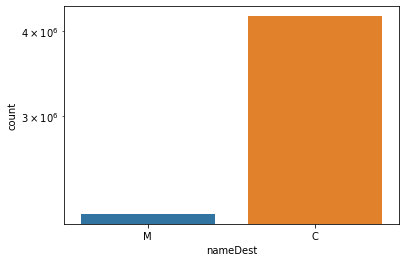

In [9]:
# Histograma para la variable 'nameDest' con escala logarítmica en el eje y
df = fraud['nameDest'].str[:1]
fraud['nameDest'] = df.values
g = sns.countplot(x="nameDest", data=fraud)
g.set_yscale("log")

In [10]:
fraud['nameDest'].value_counts()

C    4211125
M    2151495
Name: nameDest, dtype: int64

Se aprecia que la clase 'C' posee el doble de valores que la clase 'M'. 

Se realiza también un histograma para la variable $\texttt{type}$, como el que se muestra a continuación.

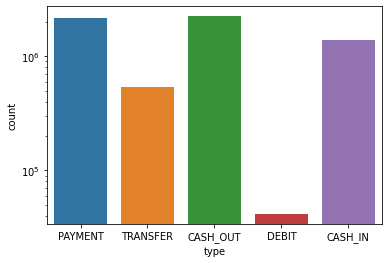

In [11]:
# Histograma para la variable 'type' con escala logarítmica en el eje y
g = sns.countplot(x="type", data=fraud)
g.set_yscale("log")

In [12]:
fraud['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [13]:
# Cantidad de niveles distintos para las variables tipo 'int64'
for col in fraud.select_dtypes(include='int64'):
    print('Variable tipo \"int64\": Número de niveles distintos para la variable', col, ':', fraud[col].nunique())

Variable tipo "int64": Número de niveles distintos para la variable step : 743
Variable tipo "int64": Número de niveles distintos para la variable isFraud : 2
Variable tipo "int64": Número de niveles distintos para la variable isFlaggedFraud : 2


### Variables numéricas

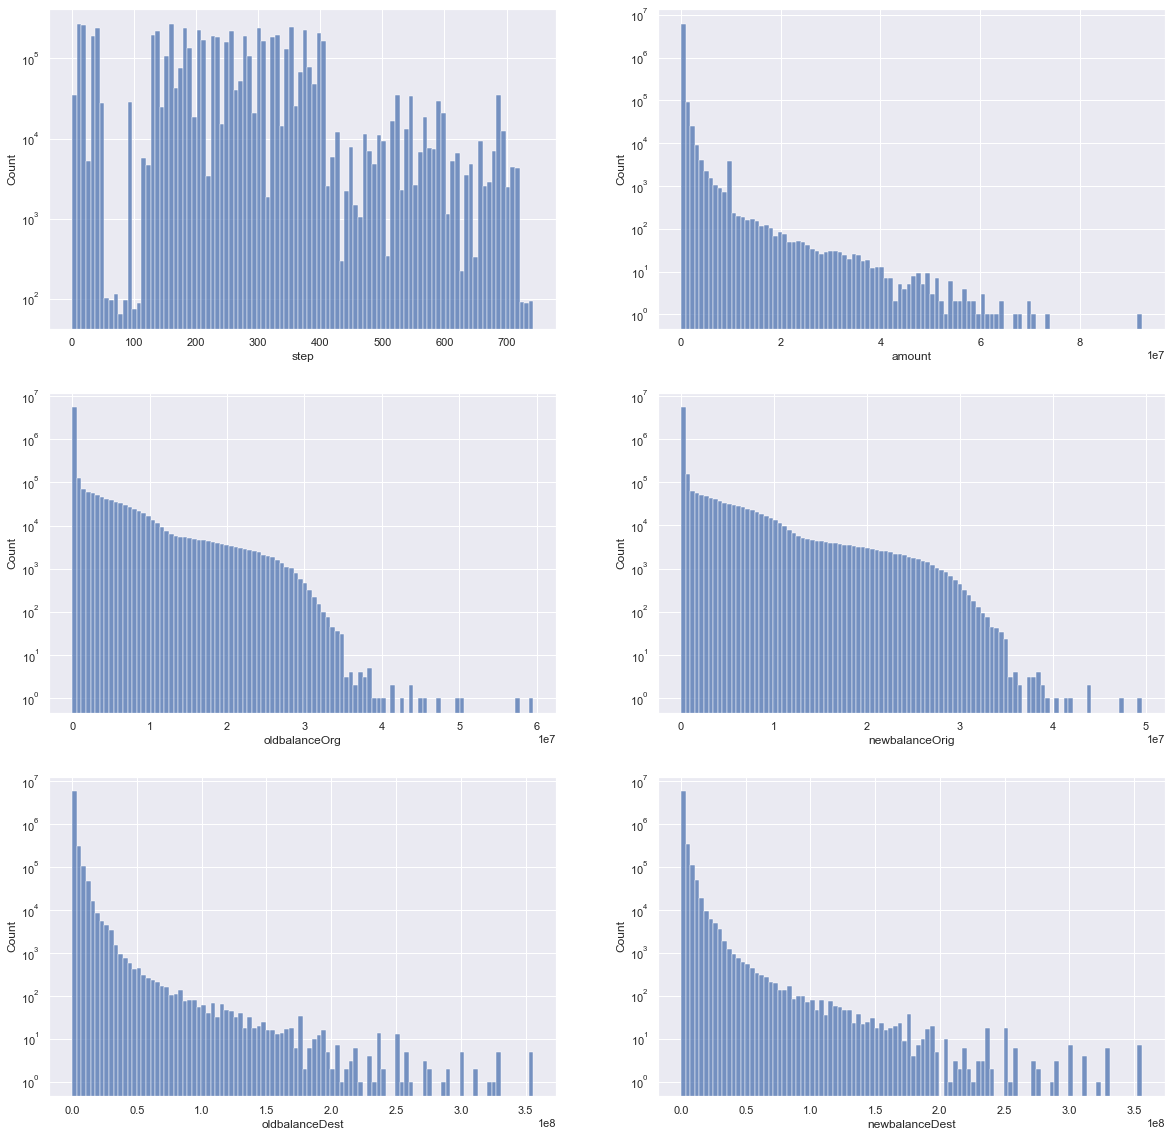

In [14]:
# Histogramas de variables tipo 'int64' y 'float'
sns.set(style="darkgrid")
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
df = fraud.select_dtypes(include=['int64', 'float'])
cont = 0
for row in range(rows):
    for col in range(cols):
        df_col = df.columns[cont]
        if cont==0:
            g = sns.histplot(data=df, x=df_col, bins=100, ax=axs[row, col]) 
            #df = df.replace(0, 1e-6)
        else:
            g = sns.histplot(data=df, x=df_col, log_scale=False, bins=100, ax=axs[row, col]) 
        g.set_yscale('log')
        cont += 1

plt.show()

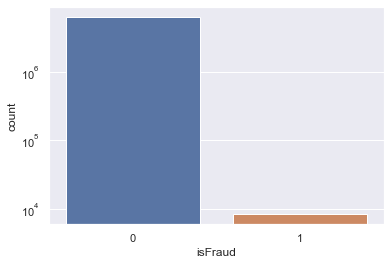

In [15]:
# Histograma para la variable 'isFraud'
g = sns.countplot(x="isFraud", data=fraud) 
g.set_yscale("log")

Observamos que las clases de la variable objetivo se encuentran totalmente desbalanceadas. Por este motivo, debemos evaluar el desempeño de los diversos métodos de balanceo de clases disponibles, entre los que podemos mencionar:
- Oversampling
- Undersampling
- Utilizar algoritmos de penzalición
- Utilizar modelos de clasificación insensibles al desbalanceo (por ejemplo, árboles de decisión)

---

## 2. Ingeniería de Features

### Eliminación de columnas
Se eliminarán las variables 'nameOrig' y 'isFlaggedFraud' dado que no aportan información a la predicción de fraude

In [16]:
cols_to_drop = ['nameOrig', 'isFlaggedFraud']
fraud2 = fraud.drop(cols_to_drop, axis=1)
fraud2.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,M,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,M,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,C,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,C,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,M,0.0,0.0,0


### Codificación de variables categóricas

In [17]:
# one-hot enconding para la variable 'type'
df = pd.get_dummies(fraud2.type)
df.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [18]:
fraud3 = pd.concat([fraud2, df], axis=1)
fraud3 = fraud3.drop('type', axis=1)
fraud3.head()

,step,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,M,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,M,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,C,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,C,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,M,0.0,0.0,0,0,0,0,1,0


In [19]:
# Codificación de la variable 'nameDest'
fraud3 = fraud3.replace({'nameDest': {'M': 0, 'C': 1}})
fraud3[['nameDest', 'isFraud']] = fraud3[['nameDest', 'isFraud']].astype(np.uint8)
fraud3['step'] = fraud3['step'].astype(np.int16)
fraud3.head()

,step,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,1,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,1,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0,0.0,0.0,0,0,0,0,1,0


### Correlación entre variables

Los siguientes análisis permiten determinar la existencia de relaciones o asociaciones entre variables. Evaluaremos los siguientes coeficientes:

- Coeficiente de correlación de Spearman: se emplea para hallar relaciones entre pares de variables **numéricas-numéricas** conociendo que sus distribuciones no se correspondan con distribuciones normales. Se utilizará para hallar relaciones entre las variables independientes tipo numéricas.
- Coeficiente de correlación de Kendall: se emplea para hallar relaciones entre pares de variables **numéricas-categóricas**, sin realizar suposiciones respecto a las distribuciones de las variables. Se utilizará para hallar relaciones entre las variables independientes tipo numéricas con la variable categórica objetivo.


In [20]:
categorical_features = list(fraud3.select_dtypes(include=['uint8']).columns.values)
numerical_features = list(set(fraud3.columns.values)-set(categorical_features))
numerical_features_plus_target = numerical_features.copy()
numerical_features_plus_target.append('isFraud')

<AxesSubplot:>

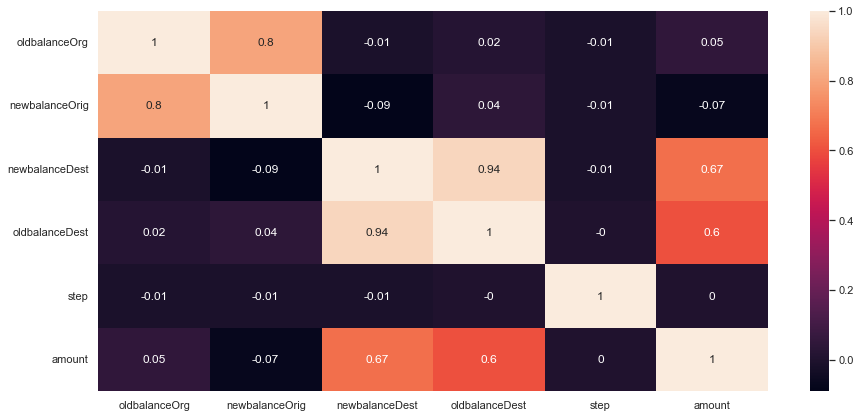

In [21]:
# Matriz de correlación con coeficiente de Spearman, redondeo a 2 decimales. Asociacion entre variables numéricas-numéricas (independientes)
corr_mat_spearman = fraud3[numerical_features].corr('spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(15,7))
sns.heatmap(data=corr_mat_spearman, annot=True, ax=axes)

In [22]:
# Listado de variables numéricas continuas con fuerte asociación monotónica
s = corr_mat_spearman.abs().unstack()
so = s.sort_values(kind="quicksort", ascending=False).drop_duplicates()
so.loc[(so<1) & (so>0.79), :] 

newbalanceDest  oldbalanceDest    0.94
newbalanceOrig  oldbalanceOrg     0.80
dtype: float64

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4868: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


<AxesSubplot:>

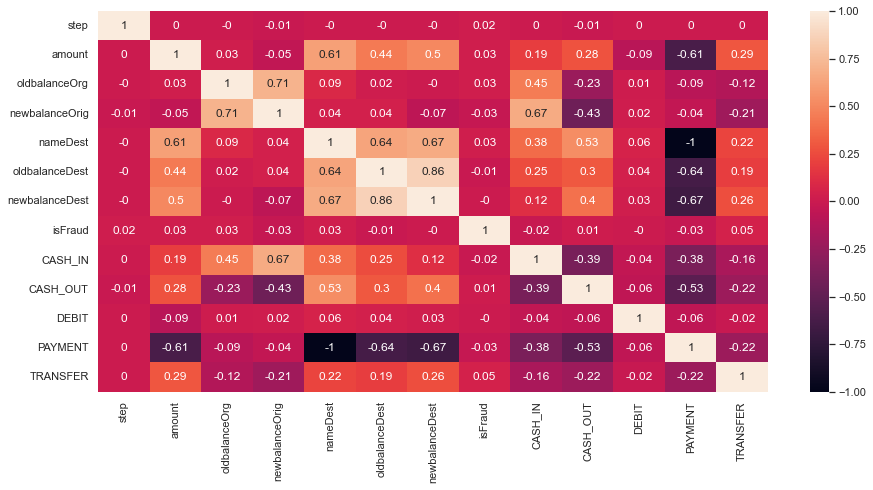

In [23]:
correlation_matrix = fraud3.corr('kendall').round(2)
fig,axes = plt.subplots(1,1,figsize=(15,7))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes)

De la evaluación de las matrices de correlación precedentes, se concluye que las variables fuertemente asociadas son 'oldbalanceDest' con 'newbalanceDest', 'oldbalanceOrg' con 'newbalanceOrig', y 'nameDest' y 'PAYMENT' (presentando este último par una colinealidad perfecta). En conclusión, se removerán las columnas 'oldbalanceDest', 'newbalanceOrig', y 'nameDest'.

In [24]:
cols_to_drop = ['nameDest', 'oldbalanceDest', 'newbalanceOrig']
fraud4 = fraud3.drop(cols_to_drop, axis=1)
fraud4.head()

,step,amount,oldbalanceOrg,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,0.0,0,0,0,0,1,0


---

## 3. Evaluación de modelos

En este apartado se evaluará el desempeño de los siguientes modelos de clasifición binaria, los cuales han sido desarrollados en el transcurso de las clases:
- Regresión logística
- Arboles de decisión
- Random forest

A continuación seleccionamos la columna 'isFraud' como variable target, y creamos una partición del dataset en train y test, usando un 20% de los datos para test y estratificando las muestras. Dicha partición va a ser común a todos los modelos con el fin de poder realizar comparaciones de las métricas corresponientes. 

In [25]:
# Definimos dataframe de predictores y variable target
target = 'isFraud'
X = fraud4.loc[:, fraud4.columns != target]
y = fraud4[target]

In [26]:
# Partición del dataset en conjuntos de train y test, usando un 20% de los datos para test y estratificando las muestras
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12, test_size=0.2)
print('Tamaño de los conjuntos de train y test:',len(X_train),'y',len(X_test))

Tamaño de los conjuntos de train y test: 5090096 y 1272524


In [27]:
# Chequeo de estratificacion de clases en las variables target de train y test
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


Para tratar el problema del desbalanceo de las clases en la variable target, se implementa el método de **under-sampling con reposición**. El motivo de la elección de esta técnica radica en la necesidad de contar con un subconjunto reducido del dataset original para que pueda ser manipulado localmente con los recursos computacionales disponibles. 

*Nota 1: se definirá un pipeline para manipular automáticamente los subconjuntos under-sampleados, y de esta manera evitar la pérdida de información (data leakage).*

In [28]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

La evaluación del desempeño de los modelos se realizará con métricas de precisión y recall.

### 3.1. Regresión logística

### 3.1.1. Datos originales (sin balancear clases en variable target) 

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


In [30]:
lista_prec0, lista_rec0, lista_prec1, lista_rec1, lista_balacc = [], [], [], [], []

In [31]:
# Función para obtener métricas sobre el modelo ajustado
def report(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    cr = classification_report(y_test, y_pred, output_dict=True)

    print(classification_report(y_test, y_pred))
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test, y_proba[:,1]), 4))
    precision, recall, threshold = precision_recall_curve(y_test, y_proba[:,1])
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall, precision), 4))
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues')

    return model, cr

In [32]:
# Seleccion de features para estandarizar (sólo variables numéricas)
numeric_features = list(fraud4.select_dtypes(include='float64').columns.values)
numeric_features.append('step')
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Creación del modelo a través de pipeline
lr_model = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    LogisticRegressionCV(random_state=0)
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.65      0.06      0.12      1643

    accuracy                           1.00   1272524
   macro avg       0.83      0.53      0.56   1272524
weighted avg       1.00      1.00      1.00   1272524

Area bajo la curva ROC: 0.7756
Area bajo la curva Precision-Recall: 0.1275


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


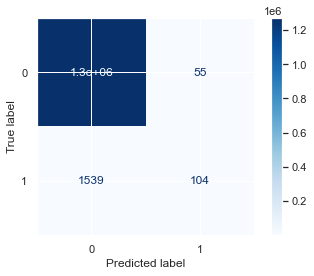

In [33]:
# Ajuste del modelo y reporte de métricas
lr_model_fit, cr_lr = report(lr_model, X_train, X_test, y_train, y_test)

In [34]:
lista_prec0.append(cr_lr['0']['precision'])
lista_rec0.append(cr_lr['0']['recall'])
lista_prec1.append(cr_lr['1']['precision'])
lista_rec1.append(cr_lr['1']['recall'])
lista_balacc.append([])

### 3.1.2. Aplicando under-sampling

In [35]:
# Creación del modelo con estrategia de under sampling
lr_model_us = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomUnderSampler(random_state=0, replacement=True),
    LogisticRegressionCV(random_state=0)
)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93   1270881
           1       0.01      0.68      0.01      1643

    accuracy                           0.88   1272524
   macro avg       0.50      0.78      0.47   1272524
weighted avg       1.00      0.88      0.93   1272524

Area bajo la curva ROC: 0.8172
Area bajo la curva Precision-Recall: 0.0243


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


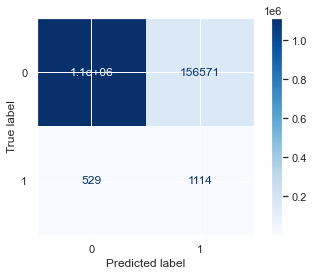

In [36]:
# Ajuste del modelo y reporte de métricas
lr_model_us_fit, cr_lr_us = report(lr_model_us, X_train, X_test, y_train, y_test)

In [37]:
lista_prec0.append(cr_lr_us['0']['precision'])
lista_rec0.append(cr_lr_us['0']['recall'])
lista_prec1.append(cr_lr_us['1']['precision'])
lista_rec1.append(cr_lr_us['1']['recall'])
lista_balacc.append([])

### 3.1.3. Aplicando under-sampling con métrica "balanced_accuracy"

La documentación de *imbalanced-learn* (https://imbalanced-learn.org/stable/common_pitfalls.html) recomienda el uso de la métrica *balanced_accuracy* para evaluar la performance del modelo elegido en presencia de clases desbalanceadas. A su vez, muestra una estrategia de ajuste del modelo mediante validacion cruzada, luego de la cual se obtiene un valor promediado de dicha métrica.

La métrica de *balaced accuracy* se define como el promedio entre el recall y la especificidad, la cual mide la proporción de ocurrencias negativas correctamente identificadas sobre el total de predicciones negativas realizadas por el modelo.

In [38]:
from sklearn.model_selection import cross_validate
lr_model_usCV = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomUnderSampler(random_state=0, replacement=True),
    LogisticRegression(random_state=0)
)
cv_results = cross_validate(
    lr_model_usCV, X_train, y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True,
    n_jobs=-1
)
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)

Balanced accuracy mean +/- std. dev.: 0.788 +/- 0.003


In [39]:
from sklearn.metrics import balanced_accuracy_score
scores = []
for fold_id, cv_model in enumerate(cv_results["estimator"]):
    scores.append(
        balanced_accuracy_score(
            y_test, cv_model.predict(X_test)
       )
    )
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{np.mean(scores):.3f} +/- {np.std(scores):.3f}"
)

Balanced accuracy mean +/- std. dev.: 0.777 +/- 0.001


In [40]:
lista_prec0.append([])
lista_rec0.append([])
lista_prec1.append([])
lista_rec1.append([])
lista_balacc.append(np.mean(scores))

### 3.2. Árboles de decisión

### 3.2.1. Datos originales (sin balancear clases en variable target) 

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [42]:
# Arbol de decisión con profundidad 10
dt_model = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    DecisionTreeClassifier(criterion='entropy', random_state=0)
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.65      0.65      0.65      1643

    accuracy                           1.00   1272524
   macro avg       0.82      0.82      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

Area bajo la curva ROC: 0.8248
Area bajo la curva Precision-Recall: 0.6481


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


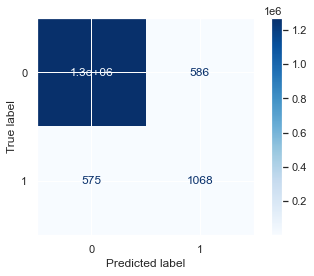

In [43]:
# Ajuste del modelo y reporte de métricas
dt_model_fit, cr_dt = report(dt_model, X_train, X_test, y_train, y_test)

In [44]:
lista_prec0.append(cr_dt['0']['precision'])
lista_rec0.append(cr_dt['0']['recall'])
lista_prec1.append(cr_dt['1']['precision'])
lista_rec1.append(cr_dt['1']['recall'])
lista_balacc.append([])

### 3.2.2. Aplicando under-sampling

In [45]:
dt_model_us = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomUnderSampler(random_state=0, replacement=True),
    DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=10)
)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1270881
           1       0.02      0.96      0.03      1643

    accuracy                           0.93   1272524
   macro avg       0.51      0.94      0.50   1272524
weighted avg       1.00      0.93      0.96   1272524

Area bajo la curva ROC: 0.9827
Area bajo la curva Precision-Recall: 0.2963


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


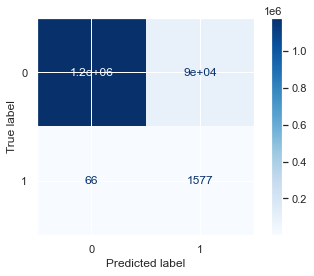

In [46]:
# Ajuste del modelo y reporte de métricas
dt_model_us_fit, cr_us_fit = report(dt_model_us, X_train, X_test, y_train, y_test)

In [47]:
lista_prec0.append(cr_us_fit['0']['precision'])
lista_rec0.append(cr_us_fit['0']['recall'])
lista_prec1.append(cr_us_fit['1']['precision'])
lista_rec1.append(cr_us_fit['1']['recall'])
lista_balacc.append([])

### 3.2.3. Aplicando under-sampling con métrica "balanced_accuracy"

In [48]:
dt_model_usCV = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomUnderSampler(random_state=0, replacement=True),
    DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=10)
)
cv_results = cross_validate(
    dt_model_usCV, X_train, y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True,
    n_jobs=-1
)
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)

Balanced accuracy mean +/- std. dev.: 0.950 +/- 0.003


In [49]:
scores = []
for fold_id, cv_model in enumerate(cv_results["estimator"]):
    scores.append(
        balanced_accuracy_score(
            y_test, cv_model.predict(X_test)
       )
    )
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{np.mean(scores):.3f} +/- {np.std(scores):.3f}"
)

Balanced accuracy mean +/- std. dev.: 0.949 +/- 0.004


In [50]:
lista_prec0.append([])
lista_rec0.append([])
lista_prec1.append([])
lista_rec1.append([])
lista_balacc.append(np.mean(scores))

### 3.3. Random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

### 3.3.1. Utilizando todo el dataset

In [52]:
rf_model = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomForestClassifier(criterion='entropy', random_state=23)
)

In [53]:
# Implementación de búsqueda de profundidad óptima del árbol utilizando cross-validation
n_estimators = [10] #Evaluo solo una profundidad
parameters = dict(randomforestclassifier__n_estimators=n_estimators)
rf_modelCV = GridSearchCV(rf_model, parameters)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.59      0.73      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.79      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524

Area bajo la curva ROC: 0.928
Area bajo la curva Precision-Recall: 0.7818


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


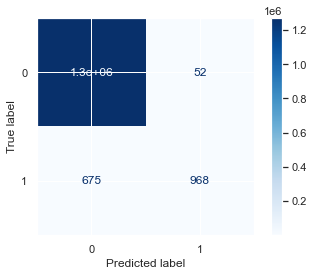

In [54]:
# Ajuste del modelo y reporte de métricas
rf_modelCVfit, cr_rf = report(rf_modelCV, X_train, X_test, y_train, y_test)

In [55]:
lista_prec0.append(cr_rf['0']['precision'])
lista_rec0.append(cr_rf['0']['recall'])
lista_prec1.append(cr_rf['1']['precision'])
lista_rec1.append(cr_rf['1']['recall'])
lista_balacc.append([])

### 3.3.2. Aplicando under-sampling

In [56]:
rf_model_us = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomUnderSampler(random_state=0, replacement=True, sampling_strategy='majority'),
    RandomForestClassifier(criterion='entropy', random_state=23)
)

In [57]:
# Implementación de búsqueda de profundidad óptima del árbol utilizando cross-validation
n_estimators = [10, 15, 20, 25, 30]
parameters = dict(randomforestclassifier__n_estimators=n_estimators)
rf_model_us_CV = GridSearchCV(rf_model_us, parameters) 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.96      0.07      1643

    accuracy                           0.96   1272524
   macro avg       0.52      0.96      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

Area bajo la curva ROC: 0.9936
Area bajo la curva Precision-Recall: 0.5101


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


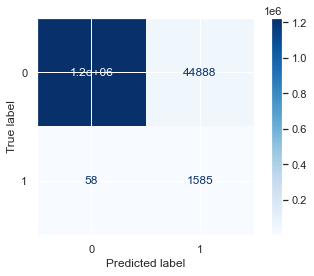

In [58]:
# Ajuste del modelo y reporte de métricas
rf_model_us_CV_fit, cr_rf_usCV = report(rf_model_us_CV, X_train, X_test, y_train, y_test)

In [59]:
# Profundidad optima lograda a partir de CV
rf_modelCVfit.best_params_

{'randomforestclassifier__n_estimators': 10}

In [60]:
lista_prec0.append(cr_rf_usCV['0']['precision'])
lista_rec0.append(cr_rf_usCV['0']['recall'])
lista_prec1.append(cr_rf_usCV['1']['precision'])
lista_rec1.append(cr_rf_usCV['1']['recall'])
lista_balacc.append([])

### 3.3.3. Aplicando under-sampling con métrica "balanced_accuracy"

In [61]:
rf_model_usCV = make_pipeline(
    ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)]),
    RandomUnderSampler(random_state=0, replacement=True),
    RandomForestClassifier(criterion='entropy', random_state=23, max_depth=10)
)
cv_results = cross_validate(
    rf_model_usCV, X_train, y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True,
    n_jobs=-1
)
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)

Balanced accuracy mean +/- std. dev.: 0.964 +/- 0.002


In [62]:
scores = []
for fold_id, cv_model in enumerate(cv_results["estimator"]):
    scores.append(
        balanced_accuracy_score(
            y_test, cv_model.predict(X_test)
       )
    )
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{np.mean(scores):.3f} +/- {np.std(scores):.3f}"
)

Balanced accuracy mean +/- std. dev.: 0.962 +/- 0.001


In [63]:
lista_prec0.append([])
lista_rec0.append([])
lista_prec1.append([])
lista_rec1.append([])
lista_balacc.append(np.mean(scores))

## Sumario 

In [64]:
lista_modelos = ['RL sin undersampling', 'RL con undersampling', 'RL con undersampling y CV', 'DT sin undersampling', 'DT con undersampling', 'DT con undersampling y CV', 'RF sin undersampling', 'RF con undersampling', 'RF con undersampling y CV']
data = {'Modelo': lista_modelos, 'Precision-Clase0': lista_prec0, 'Recall-Clase0': lista_rec0, 'Precision-Clase1': lista_prec1, 'Recall-Clase1': lista_rec1, 'Balanced-Accuracy': lista_balacc}
df = pd.DataFrame(data)  
df

,Modelo,Precision-Clase0,Recall-Clase0,Precision-Clase1,Recall-Clase1,Balanced-Accuracy
0,RL sin undersampling,0.99879,0.999957,0.654088,0.063299,[]
1,RL con undersampling,0.999525,0.876801,0.007065,0.678028,[]
2,RL con undersampling y CV,[],[],[],[],0.777363
3,DT sin undersampling,0.999548,0.999539,0.645707,0.65003,[]
4,DT con undersampling,0.999944,0.92879,0.017127,0.95983,[]
5,DT con undersampling y CV,[],[],[],[],0.948812
6,RF sin undersampling,0.999469,0.999959,0.94902,0.589166,[]
7,RF con undersampling,0.999953,0.96468,0.034106,0.964699,[]
8,RF con undersampling y CV,[],[],[],[],0.962111


---
# **Conclusiones**

En la etapa de construcción de modelos, se ensayaron modelos de regresión logística, de árboles de decisión y de Random Forest y en tres etapas: 
- i) dataset sin balanceado de clases en la variable target. Evaluación de métricas tradicionales de recall y precision.
- ii) dataset con balanceado de clases en la variable target. Evaluación de métricas tradicionales de recall y precision.
- iii) dataset con balanceado de clases en la variable target. Evaluación de métrica de balanced_accuracy luego de realizar validación cruzada

Recordamos que las métricas de precision y recall se definen como:

$$
\mathrm{Precision} = \frac{TP}{TP+FP},\quad \mathrm{Recall} = \frac{TP}{TP+FN},
$$
donde, para el caso estudiado, la cantidad de falsos positivos (FP) refiere al caso donde el modelo predice fraude cuando en realidad la operación es válida, mientras que la cantidad de falsos negativos (FN) corresponde al caso donde el modelo predice operación válida cuando en realidad se trata de fraude.

En los casos evaluados bajo la etapa i), la métrica de precision y recall para la clase 0 fue muy alta. Por otro lado, la precisión para la clase 1 se redujo sensiblemente, mientras que el recall sufrió un deterioro hasta valores por debajo de 0.5. Este comportamiento representaría pérdidas económicas muy elevadas para una institucion bancaria dado que el modelo permitiría operaciones fraudulentas dándolas como válidas. 

Al evaluar los casos correspondientes a la etapa ii), también se registraron valores elevados de precision y recall para la clase 0, mientras que para la clase 1 el comportamiento de los modelos evaluados fue inverso al correspondiente al caso i): se registró un incremento notable de la métrica de recall a expensas del deteriorio de la métrica de precision. Es decir, el balanceo de las clases en la variable target priorizó la reducción de FN evitando dar como válidas operaciones realmente fraudulentas, a costo de aumentar la tasa de FP. Este comportamiento minimiza las pérdidas y/o perjuicios sobre la institución bancaria, a expensas de generar mayores reclamos por parte de los clientes ya que el modelo bloquearía operaciones realmente válidas.

Con los modelos analizados, no fue posible encontrar una configuración que asegure al mismo tiempo una elevada precisión y un elevado recall en la clase minoritaria.

En la etapa iii), la métrica obtenida de balanced_accuracy resultó máxima en el caso del modelo de Random Forest con undersampling y cross-validation, a la vez que el balanced_accuracy resultó algo inferior en los dos modelos restantes. En apariencia, esta métrica no sería suficiente para determinar la optimalidad del modelo dado que no permite computar la proporción de FP y FN, con lo cual no se tiene una noción del desempeño del modelo respecto a de las operaciones válidas dadas como fraudulentas ni a las operaciones fraudulentas dadas como válidas. 

En conclusión, los modelos presentados no son útiles para el objetivo propuesto. Sería necesario evaluar configuraciones diferentes de los mismos modelos o evaluar modelos diferentes, en los que las métricas de recall y precision se mantengan elevadas para las dos clases.